In [31]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

In [27]:
# 하이퍼파라미터 설정
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
WEIGHT_DECAY = 0
EPOCHS = 500

In [28]:
# YOLOv1 네트워크 아키텍처 구성
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [2]:
from torchvision import transforms

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes
        return img, bboxes

transform = Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
])

In [5]:

class VOCDataset(Dataset):
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        print(len(self.annotations))

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]
                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)

        boxes = torch.tensor(boxes)  # box -> tensor 타입으로 바꾸기

        if self.transform:  # 이미지 사이즈 변경 -> tensor
            image, boxes = self.transform(image, boxes)

        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i = int(self.S * x)
            j = int(self.S * y)

            x_cell = self.S * x - i
            y_cell = self.S * y - j

            if label_matrix[i, j, 20] == 0:
                box_coordinates = torch.tensor([x_cell, y_cell, width, height])

                label_matrix[i, j, 20] = 1
                label_matrix[i, j, 21:25] = box_coordinates
                label_matrix[i, j, class_label] = 1

        for box in boxes:  # boxes: 이미지 마다 Label 이 저장
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i = int(self.S * x)
            j = int(self.S * y)

            x_cell = self.S * x - i
            y_cell = self.S * y - j

            if label_matrix[i, j, 20] == 0:
                box_coordinates = torch.tensor([x_cell, y_cell, width, height])

                label_matrix[i, j, 20] = 1
                label_matrix[i, j, 21:25] = box_coordinates
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [14]:
# VOCDataset 및 Compose 클래스 정의 부분은 이전 코드에서 가져온다고 가정
# 이미 정의된 부분은 생략

BATCH_SIZE = 32

ANNOT_DIR = "/Users/kisoup/ready/Area/BME major/4-1/Deep Learning/code/12 . YOLO/data/30examples.csv"
IMG_DIR = "/Users/kisoup/ready/Area/BME major/4-1/Deep Learning/code/12 . YOLO/data/images"
LABEL_DIR = "/Users/kisoup/ready/Area/BME major/4-1/Deep Learning/code/12 . YOLO/data/labels"

train_dataset = VOCDataset(
    csv_file=ANNOT_DIR,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
    transform=transform,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

img, box = next(iter(train_loader))


30


In [15]:

def imgshow(img, box):
    inx = torch.where(box[..., 20].view(-1) == 1)[0]
    index = []
    for i in inx:
        index.append(divmod(i.numpy(), 7))

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img.permute(1, 2, 0))

    for _, (i, j) in enumerate(index):
        dx, dy, dw, dh = box[i, j, 21:25]
        x = dx * 64 + i * 64
        y = dy * 64 + j * 64
        w = int(dw * 448)
        h = int(dh * 448)
        xx = np.max((int(x - w / 2), 0))
        yy = np.max((int(y - h / 2), 0))
        ax.add_patch(
            patches.Circle(
                (x, y),
                edgecolor='red',
                fill=False
            )
        )
        ax.add_patch(
            patches.Rectangle(
                (xx, yy),
                w, h,
                edgecolor='red',
                fill=False
            )
        )



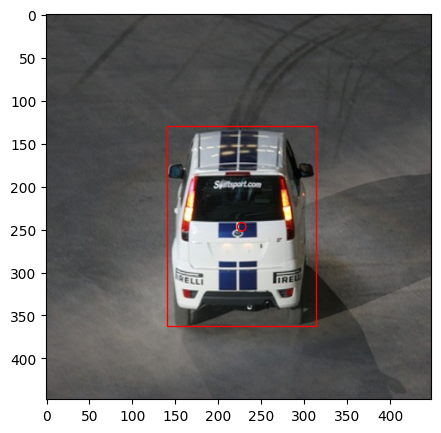

In [16]:
imgshow(img[11], box[11])

In [18]:
# Convolution -> BatchNorm -> LeakyReLU 블록 정의
class CBABlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CBABlock, self).__init__()
        # Convolution 레이어 정의
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        # BatchNorm 레이어 정의
        self.batchnorm = nn.BatchNorm2d(out_channels)
        # LeakyReLU 활성화 함수 정의
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        # 순전파: Conv -> BatchNorm -> LeakyReLU
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [35]:

# YOLOv1 모델 정의
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)  # Darknet53의 컨볼루션 레이어 생성
        self.fcs = self._create_fcs(**kwargs)  # 완전 연결 층 생성

    def forward(self, x):
        x = self.darknet(x)  # 컨볼루션 레이어를 통과
        return self.fcs(torch.flatten(x, start_dim=1))  # Flatten 후 완전 연결 층을 통과

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CBABlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            # Maxpooling 레이어
            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

            # 반복적인 컨볼루션 블록
            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CBABlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CBABlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # 원본 논문에서는 다음과 같이 정의됨:
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),  # 입력을 평탄화
            nn.Linear(1024 * S * S, 496),  # 입력 크기를 496으로 줄임
            nn.Dropout(0.0),  # 드롭아웃 레이어
            nn.LeakyReLU(0.1),  # 활성화 함수
            nn.Linear(496, S * S * (C + B * 5)),  # 최종 출력 크기를 설정
        )

    @staticmethod
    def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
        """
        두 개의 박스 세트 간의 교차 영역을 계산합니다.

        매개변수:
        - boxes_preds: 예측된 박스 (N, 4)
        - boxes_labels: 실제 라벨 박스 (N, 4)
        - box_format: "midpoint" 또는 "corners", 박스의 좌표 형식을 지정

        반환:
        - IoU: 각 박스 쌍의 교차 영역 (N,)
        """
        if box_format == "midpoint":
            # 예측 박스의 좌표 계산 (중심점, 너비, 높이)
            box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2  # x - w/2
            box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2  # y - h/2
            box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2  # x + w/2
            box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2  # y + h/2

            # 실제 라벨 박스의 좌표 계산 (중심점, 너비, 높이)
            box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
            box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
            box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
            box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

        elif box_format == "corners":
            # 예측 박스의 좌표 계산 (왼쪽 위, 오른쪽 아래)
            box1_x1 = boxes_preds[..., 0:1]
            box1_y1 = boxes_preds[..., 1:2]
            box1_x2 = boxes_preds[..., 2:3]
            box1_y2 = boxes_preds[..., 3:4]

            # 실제 라벨 박스의 좌표 계산 (왼쪽 위, 오른쪽 아래)
            box2_x1 = boxes_labels[..., 0:1]
            box2_y1 = boxes_labels[..., 1:2]
            box2_x2 = boxes_labels[..., 2:3]
            box2_y2 = boxes_labels[..., 3:4]

        # 교차 영역의 좌표 계산
        x1 = torch.max(box1_x1, box2_x1)
        y1 = torch.max(box1_y1, box2_y1)
        x2 = torch.min(box1_x2, box2_x2)
        y2 = torch.min(box1_y2, box2_y2)

        # .clamp(0)는 교차하지 않을 경우를 처리
        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

        # 각 박스의 영역 계산
        box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
        box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

        # IoU 계산
        return intersection / (box1_area + box2_area - intersection + 1e-6)

In [25]:

class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        # self.mse = mseloss(a, b)
        # def mseloss(a, b):
        #     return torch.mean((a - b) ** 2)

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S*(C+B*5)) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = Yolov1.intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = Yolov1.intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two predictions
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            bestbox * predictions[..., 26:30] + (1 - bestbox) * predictions[..., 21:25]
        )
        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4]) + 1e-6
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ======================== #
        #    FOR OBJECT LOSS       #
        # ======================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================== #
        #  FOR NO OBJECT LOSS      #
        # ======================== #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        # ======================== #
        #    FOR CLASS LOSS        #
        # ======================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [29]:

# 모델 초기화
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)

# 옵티마이저 설정
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# 손실 함수 설정
loss_fn = YoloLoss()

In [36]:
# 모델을 훈련 모드로 설정
model.train()

# 훈련 루프
for epoch in range(EPOCHS):
    mean_loss = []

    for batch_idx, (x, y) in enumerate(tqdm(train_loader)):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

  0%|          | 0/1 [00:23<?, ?it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [30, 7, 7, 2]], which is output 0 of AsStridedBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [ ]:
# 모델을 평가 모드로 설정
model.eval()

# 모델을 장치로 이동
model.to(DEVICE)

# 예측 수행
pred = model(x)

# 예측 결과를 적절한 형상으로 변환
pred = pred.view(-1, 7, 7, 30)

# 특정 인덱스 설정
inx = 3
pred[inx, ..., 20] = (pred[inx, ..., 20] > 0.60) * 1

# 결과 시각화
imgshow(x[inx].detach().cpu(), pred[inx].detach().cpu())